# Imports

In [1]:
import numpy as np
import pandas as pd
import itertools
import math
import random
import sys
import operator

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import xgboost as xgb
from sklearn import preprocessing
from sklearn import metrics
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import pipeline
from sklearn import feature_selection

In [2]:
rseed = random.seed(42)

# Data

In [3]:
train_orig = pd.read_csv('../data/train_master.csv')
test_orig = pd.read_csv('../data/test_master.csv')
event_type = pd.read_csv('../data/event_type.csv')
resource_type = pd.read_csv('../data/resource_type.csv')
severity_type = pd.read_csv('../data/severity_type.csv')
log_feature = pd.read_csv('../data/log_feature.csv')
sample = pd.read_csv('../data/sample_submission.csv')

# Functions

In [4]:
def logloss(y_pred, y_true):
    nrows = y_pred.shape[0]
    y_pred = y_pred + 1e-15
    probs = y_pred[list(range(nrows)), y_true.astype(int)]
    return -np.sum(np.log(probs)) / nrows

In [5]:
def report(grid_scores, n_top=5):
    top_scores = sorted(grid_scores, key=operator.itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model #{0}".format(i + 1))
        print("Mean CV score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Est. Kscore: {:.3f}".format(1/score.mean_validation_score))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [6]:
class MyXGBClassifier(object):

    def __init__(self, n_rounds=100, **params):
        self.clf = None
        self.params = params        
        self.n_rounds = n_rounds
        self.dtrain = None

    def fit(self, X, Y):
        num_boost_round = self.n_rounds
        self.dtrain = xgb.DMatrix(X, label=Y)
        self.clf = xgb.train(params=self.params, dtrain=self.dtrain, num_boost_round=num_boost_round)

    def predict(self, X):
        Y = self.predict_proba(X)
        y = np.argmax(Y, axis=1)
        return np.array(y)

    def predict_proba(self, X):
        dtest = xgb.DMatrix(X)
        return self.predict(dtest)

    def get_params(self, deep=True):
        return self.params

    def set_params(self, **params):
        self.params.update(params)
        return self

    def logloss(self, X, Y):
        return logloss(self, X, Y)

    def score(self, X, Y):
        y = self.predict_proba(X)
        return 1. / logloss(y, Y)

In [8]:
def filter_on_total(x, distribution, total=1, value='Rare'):
    try:
        if distribution[x] < total:
            return value
    except (ValueError, KeyError):
        return np.nan
    else:
        return x

In [9]:
def resource_type_features(df):
    resource_type_dummies = pd.get_dummies(resource_type['resource_type'])
    resource_dummy = pd.concat([resource_type, resource_type_dummies],
                               axis=1)
    resource_grpd = resource_dummy.groupby(resource_dummy.id).sum()
    df_resource = pd.merge(df, resource_grpd, left_on='id', right_index=True)
    return df_resource.drop(['resource_type 1', 'resource_type 2',
                             'resource_type 4',
                             'resource_type 6', 'resource_type 8',
                             'resource_type 10'], axis=1)

In [10]:
def resource_type_event_count(df):

    p = pd.merge(resource_type, event_type, on='id')
    t = p.loc[p['resource_type'] == 'resource_type 2', ['id', 'event_type']] \
        .groupby(by=['id'], as_index=False).count()
    df_two = pd.merge(df, t, on='id', how='left')

    f = p.loc[p['resource_type'] == 'resource_type 4', ['id', 'event_type']] \
        .groupby(by='id', as_index=False).count()
    df_four = pd.merge(df_two, f, on='id', how='left')

    e = p.loc[p['resource_type'] == 'resource_type 8', ['id', 'event_type']] \
        .groupby(by='id', as_index=False).count()
    df_eight = pd.merge(df_four, e, on='id', how='left')

    t = p.loc[p['resource_type'] == 'resource_type 10', ['id', 'event_type']] \
        .groupby(by='id', as_index=False).count()
    df_ten = pd.merge(df_eight, t, on='id', how='left')

    return df_ten

In [11]:
def resource_type_log(df):

    p = pd.merge(resource_type, log_feature, on='id')
    t = p.loc[(p['resource_type'] == 'resource_type 1'), ['id', 'log_feature']] \
        .groupby(by='id', as_index=False).count()
    df_one = pd.merge(df, t, on='id', how='left')

    tw = p.loc[(p['resource_type'] == 'resource_type 2'), ['id', 'log_feature']] \
        .groupby(by='id', as_index=False).count()
    df_two = pd.merge(df_one, tw, on='id', how='left')

    se = p.loc[(p['resource_type'] == 'resource_type 7'), ['id', 'log_feature']] \
        .groupby(by='id', as_index=False).count()
    df_se = pd.merge(df_two, se, on='id', how='left')

    ei = p.loc[(p['resource_type'] == 'resource_type 8'), ['id', 'log_feature']] \
        .groupby(by='id', as_index=False).count()
    df_ei = pd.merge(df_se, ei, on='id', how='left')

    n = p.loc[(p['resource_type'] == 'resource_type 9'), ['id', 'log_feature']] \
        .groupby(by='id', as_index=False).count()
    df_n = pd.merge(df_ei, n, on='id', how='left')

    return df_n

In [12]:
def resource_type_log_sum(df):

    p = pd.merge(resource_type, log_feature, on='id')
    t = p.loc[(p['resource_type'] == 'resource_type 3'), ['id', 'volume']] \
        .groupby(by='id', as_index=False).sum()
    df_one = pd.merge(df, t, on='id', how='left')

    f = p.loc[(p['resource_type'] == 'resource_type 4'), ['id', 'volume']] \
        .groupby(by='id', as_index=False).sum()
    df_f = pd.merge(df, f, on='id', how='left')

    return df_f

In [13]:
def resource_type_log_total(df):

    p = pd.merge(resource_type, log_feature, on='id')

    # resource type 2
    t = p.loc[(p['resource_type'] == 'resource_type 2'), ['id', 'log_feature']] \
        .groupby(by='id', as_index=False).count()

    t.loc[:, 'volume'] = p.loc[(p['resource_type'] == 'resource_type 2'), ['id', 'volume']] \
        .groupby(by='id', as_index=False).sum()['volume']

    t.loc[:, 'total log volume two'] = t['volume'] / t['log_feature']

    df_one = pd.merge(df, t[['id', 'total log volume two']], on='id', how='left')

    # resource type ten
    te = p.loc[(p['resource_type'] == 'resource_type 10'), ['id', 'log_feature']] \
        .groupby(by='id', as_index=False).count()

    te.loc[:, 'volume'] = p.loc[(p['resource_type'] == 'resource_type 10'), ['id', 'volume']] \
        .groupby(by='id', as_index=False).sum()['volume']

    te.loc[:, 'total log volume ten'] = te['log_feature'] * te['volume']

    df_te = pd.merge(df_one, te[['id', 'total log volume ten']], on='id', how='left')

    return df_te

In [14]:
def resource_type_severity(df):

    p = pd.merge(resource_type, severity_type, on='id')
    p.loc[:, 'resource type severity'] = \
        ((p['resource_type'] == 'resource_type 6') &
        (p['severity_type'] == 'severity_type 1')).astype(float)

    t = p[['id', 'resource type severity']].groupby(by='id', as_index=False).median()

    return pd.merge(df, t, on='id', how='left')

In [15]:
def severity_type_features(df):

    severity_type_dummies = pd.get_dummies(severity_type['severity_type'])
    severity_dummy = pd.concat([severity_type, severity_type_dummies],
                               axis=1)

    severity_grpd = severity_dummy.groupby(severity_dummy.id).sum()

    df_severity = pd.merge(df, severity_grpd, left_on='id', right_index=True)
    return df_severity

In [16]:
def severity_high(df):

    p = severity_type[['id', 'severity_type']]

    p.loc[:, 'high log severity'] = (p['severity_type'].isin(['severity_type 3',
                                                              'severity_type 4',
                                                              'severity_type 5'])).astype(float)
    ret = pd.merge(df, p[['id', 'high log severity']], on='id', how='left')
    return ret

In [17]:
def severity_event(df):

    p = pd.merge(severity_type, event_type, on='id')
    t = p.loc[(p['severity_type'] == 'severity_type 1'), ['id', 'event_type']] \
        .groupby(by='id', as_index=False).count()
    df_one = pd.merge(df, t, on='id', how='left')

    return df_one

In [18]:
def severity_log(df):

    p = pd.merge(severity_type, log_feature, on='id')

    tw = p.loc[(p['severity_type'] == 'severity_type 2'), ['id', 'log_feature']] \
        .groupby(by='id', as_index=False).count()
    df_tw = pd.merge(df, tw, on='id', how='left')

    return df_tw

In [19]:
def severity_log_sum(df):

    p = pd.merge(severity_type, log_feature, on='id')

    t = p.loc[(p['severity_type'] == 'severity_type 2'), ['id', 'log_feature']] \
        .groupby(by='id', as_index=False).count()
    t.loc[:, 'severity_volume'] = p.loc[(p['severity_type'] == 'severity_type 2'), ['id', 'volume']] \
        .groupby(by='id', as_index=False).sum()

    t.loc[:, 'severity_log_volume'] = t['severity_volume'] / t['log_feature']
    df_one = pd.merge(df, t[['id', 'severity_log_volume']], on='id', how='left')

    return df_one

In [20]:
def log_features(df):

    log_table = pd.pivot_table(
        log_feature, values='volume',
        index='id', columns='log_feature',
        aggfunc=np.sum, fill_value=0
    )
    df_log = pd.merge(df, log_table, left_on='id', right_index=True)

    return df_log

In [21]:
def log_feature_volume(df):

    g = log_feature[['id', 'volume']].groupby(by='id', as_index=False).sum()
    ret_g = pd.merge(df, g, on='id', how='left')

    h = log_feature[['id', 'log_feature']].groupby(by='id', as_index=False).count()
    i = pd.merge(h, g, on='id', how='left')

    i.loc[:, 'feature_by_volume'] = i['log_feature'] * i['volume']
    ret = pd.merge(ret_g, i[['id', 'feature_by_volume']], on='id', how='left')

    return ret

In [22]:
def log_feature_prob(train, test, level=0):

    t = pd.merge(train[['id', 'fault_severity']], log_feature, on='id',
                 how='left').drop_duplicates()

    log_given_severity = \
       t.loc[t['fault_severity'] == level, 'log_feature'].value_counts() / \
       t['fault_severity'].value_counts()[level]

    severity_prob = \
        t['fault_severity'].value_counts()[level] / len(t)

    log_probs = \
        t['log_feature'].value_counts() / len(t)

    log_feature_probs = \
        (log_given_severity * severity_prob) / log_probs

    prob_df = pd.DataFrame({'probs': log_feature_probs})

    p = pd.merge(t, prob_df, left_on='log_feature', right_index=True, how='left')
    prob_table = pd.pivot_table(p, values='probs', index='id', columns='log_feature',
                                aggfunc=np.mean, fill_value=0)

    train = pd.merge(train, prob_table, left_on='id', right_index=True,
                     how='left')
    test = pd.merge(test, prob_table, left_on='id', right_index=True,
                    how='left')

    return train, test

In [23]:
def dangerous_log(train, test, level=0):

    feature_count = \
        train.loc[
            (train['fault_severity'] == level),
            ['log_feature', 'volume']
        ].groupby(by='log_feature', sort=False).sum()

    feature_total = \
        train.loc[
            (train['fault_severity'] == level),
            'volume'
        ].sum()

    danger = feature_count / feature_total

    train.loc[
        (train['fault_severity'] == level) & (train['log_feature'].isin(danger.index)),
            'dangerous_log'
    ] = danger['volume']

    test.loc[
        (test['fault_severity'] == level) & (test['log_feature'].isin(danger.index)),
            'dangerous_log'
    ] = danger['volume']

    return train, test

In [24]:
def danger_log(train, test):

    train, test = dangerous_log(train, test, level=0)
    train, test = dangerous_log(train, test, level=1)
    train, test = dangerous_log(train, test, level=2)

    return train, test

In [25]:
def location_features(train, test, cutoff=0):

    train_locations = train[['location']]
    test_locations = test[['location']]

    train_locations.loc[:, 'train'] = True
    test_locations.loc[:, 'train'] = False

    train_distribution = train_locations['location'].value_counts()

    locations = pd.concat([train_locations, test_locations])
    locations.loc[:, 'location'] = locations['location'] \
        .apply(rare_category, args=(train_distribution, ),
               cutoff=cutoff, value='RareLocation')

    locations_bin = pd.get_dummies(locations['location'])
    locations_dummy = pd.concat([locations, locations_bin], axis=1)

    msk = locations_dummy['train']
    locations_dummy.drop(['train', 'location'], axis=1, inplace=True)

    train_locs = pd.concat([train, locations_dummy[msk]], axis=1)
    test_locs = pd.concat([test, locations_dummy[~msk]], axis=1)

    return train_locs, test_locs

In [26]:
def dangerous_location(train, test):

    danger = \
        (train.loc[(train['fault_severity'] == 2) | (train['fault_severity'] == 1), 'location']).value_counts() / \
        len(train.loc[(train['fault_severity'] == 2) | (train['fault_severity'] == 1), 'location'])

    msk = danger >= 0.025

    train.loc[train['location'].isin(danger[msk].index), 'dangerous'] = 1
    test.loc[test['location'].isin(danger[msk].index), 'dangerous'] = 1

    return train, test

In [27]:
def event_type_features(df):

    event_type_dummies = pd.get_dummies(event_type['event_type'])
    event_dummy = pd.concat([event_type, event_type_dummies], axis=1)

    event_grpd = event_dummy \
        .groupby(event_dummy.id).sum()

    df_event = pd.merge(df, event_grpd, left_on='id', right_index=True)
    return df_event

In [28]:
def event_resource_features(df):

    e = pd.merge(event_type, resource_type, on='id')
    p = e.loc[e['event_type'] == 'event_type 23', ['id', 'resource_type']] \
        .groupby(by='id', as_index=False).count()
    df_23 = pd.merge(df, p, on='id', how='left')

    return df_23

In [29]:
def event_log_features(df):

    l = pd.merge(event_type, log_feature, on='id')
    p = l.loc[l['event_type'] == 'event_type 15', ['id', 'volume']] \
        .groupby(by='id', as_index=False).sum()

    df_15 = pd.merge(df, p[['id', 'volume']], on='id', how='left')

    p = l.loc[l['event_type'] == 'event_type 15', ['id', 'log_feature']] \
        .groupby(by='id', as_index=False).count()

    df_15c = pd.merge(df_15, p, on='id', how='left')


    p = l.loc[l['event_type'] == 'event_type 14', ['id', 'volume']] \
        .groupby(by='id', as_index=False).sum()
    df_14 = pd.merge(df_15c, p[['id', 'volume']], on='id', how='left')

    return df_14

In [30]:
def event_severity_prob(train, test, level=0):

    t = pd.merge(train[['id', 'fault_severity']], event_type, on='id',
                 how='left').drop_duplicates()

    event_given_severity = \
        t.loc[t['fault_severity'] == level, 'event_type'].value_counts() / \
        len(t.loc[t['fault_severity'] == level])

    severity_probs = \
        len(t.loc[t['fault_severity'] == level, :]) / len(t)

    event_probs = \
        t['event_type'].value_counts() / len(t['event_type'])

    event_severity_probs = \
        (event_given_severity * severity_probs) / event_probs

    prob_df = pd.DataFrame({'probs': event_severity_probs})

    p = pd.merge(t, prob_df, left_on='event_type', right_index=True, how='left')
    prob_table = pd.pivot_table(p, values='probs', index='id', columns='event_type',
                                aggfunc=np.median, fill_value=0)

    train = pd.merge(train, prob_table, left_on='id', right_index=True,
                     how='left')
    test = pd.merge(test, prob_table, left_on='id', right_index=True,
                    how='left')

    return train, test

In [31]:
def event_severity(train, test):

    train, test = event_severity_prob(train, test, level=2)

    return train, test

In [32]:
def rare_category(x, category_distribution, cutoff=1, value='Rare'):
    try:
        if category_distribution[x] < cutoff:
            return value
    except (ValueError, KeyError):
        return np.nan
    else:
        return x

In [33]:
def base_features(df):
    a = event_type_features(df)
    a = resource_type_features(a)
    a = severity_type_features(a)
    a = log_features(a)
    a = log_feature_volume(a)
    a = severity_high(a)
    a = resource_type_event_count(a)
    return resource_type_log(a)

# Modeling Data

In [17]:
train = train_orig.copy().fillna(0)
test = test_orig.copy().fillna(0)

labels = train.fault_severity
ids = test.id

cdrop = ['evt_id','id','fault_severity','location']
train.drop(cdrop, 1, inplace=True)
cdrop = ['evt_id','id','location']
test.drop(cdrop, 1, inplace=True)

In [12]:
outfile = open('xgb.fmap', 'w')
for i, feat in enumerate(list(train.columns)):
    outfile.write('{0}\t{1}\tq\n'.format(i, feat))
outfile.close()

# Feature Importance

In [13]:
# train
params = {}
params['objective'] = 'multi:softprob'
params['num_class'] = 3
params['eval_metric'] = 'mlogloss'
params['eta'] = 0.3
params['max_depth'] = 6
params['subsample'] = 0.5
params['colsample_bytree'] = 0.9
params['silent'] = 1
num_round = 500
xgtrain = xgb.DMatrix(train, labels)
model = xgb.train(params, xgtrain, num_boost_round=num_round)

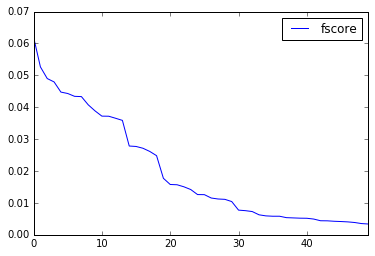

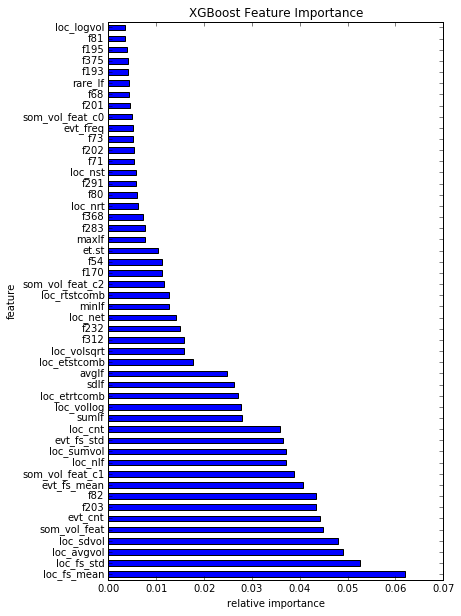

In [14]:
# feature importance
importance = model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
df_imp = pd.DataFrame(importance[:50], columns=['feature', 'fscore'])
df_imp['fscore'] = df_imp['fscore'] / df_imp['fscore'].sum()

plt.figure()
df_imp.plot()
df_imp.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()

# Hypertune

In [17]:
clf = MyXGBClassifier(n_rounds=500,
                      eta=0.3,
                      max_depth=10,
                      subsample=0.5,
                      colsample_bytree=0.9,
                      booster='gbtree',
                      objective='multi:softprob',
                      num_class=3,
                      eval_metric='mlogloss',
                      silent=0)

param_grid = {'eta': [0.05, 0.3, 0.5],
              'min_child_weight': [0.6, 0.8, 1.0],
              'max_depth': [6, 8, 10],
              'colsample_bytree': [0.3, 0.5]
              'gamma': [0.0, 0.2, 0.4]
             }

gridcv = grid_search.GridSearchCV(clf, param_grid, n_jobs=-1, cv=10)

In [ ]:
mtrain = train.as_matrix()
mlabels = labels.as_matrix()
gridcv.fit(mtrain, mlabels)

In [11]:
report(clf.grid_scores_)

Model #1
Mean CV score: 2.628 (std: 0.138)
Est. Kscore: 0.381
Parameters: {'colsample_bytree': 0.3, 'max_depth': 6}

Model #2
Mean CV score: 2.180 (std: 0.120)
Est. Kscore: 0.459
Parameters: {'colsample_bytree': 0.3, 'max_depth': 10}



# Feature Selection

In [18]:
params = {'n_rounds':500,
          'eta':0.3,
          'max_depth':6,
          'subsample':0.5,
          'colsample_bytree':0.3,
          'booster':'gbtree',
          'objective':'multi:softprob',
          'num_class':3,
          'eval_metric':'mlogloss',
          'silent':0}

best = []
for n in range(70, 105, 5):
    ch2 = feature_selection.GenericUnivariateSelect(score_func=feature_selection.chi2,
                                  mode='percentile',
                                  param=n)

    fs_train = ch2.fit_transform(train, labels)
    fs_test = ch2.transform(test)
    fs_train = xgb.DMatrix(fs_train, labels)
    scores = xgb.cv(params, fs_train, num_round, nfold=10,
                    metrics={'mlogloss'}, seed=rseed)
    best.append((n, scores[(scores['test-mlogloss-mean'] == min(scores['test-mlogloss-mean']))].values[0]))
print best

KeyboardInterrupt: 

# Submit

In [9]:
# predict xgboost
cdrop = ['evt_id','id']
test.drop(cdrop, 1, inplace=True)
mtest = test.as_matrix()

In [10]:
clf = MyXGBClassifier(n_rounds=500,
                      eta=0.3,
                      max_depth=10,
                      subsample=0.5,
                      colsample_bytree=0.9,
                      booster='gbtree',
                      objective='multi:softprob',
                      num_class=3,
                      eval_metric='mlogloss',
                      silent=0)

In [11]:
mtrain = train.as_matrix()
mlabels = labels.as_matrix()
clf.fit(mtrain, mlabels)

In [19]:
predictions = clf.predict_proba(mtest)
predictions_df = pd.DataFrame({
        'id': ids,
        'predict_0': predictions[:, 0],
        'predict_1': predictions[:, 1],
        'predict_2': predictions[:, 2]
    })
predictions_df.to_csv('xgb_X.XXXXX.csv', index=False)

# Scratch

In [1]:
!pwd

/Users/cavagnolo/ml_fun/telstra/testing


In [2]:
train = pd.read_csv('../data/train_master.csv')
test = pd.read_csv('../data/test_master.csv')

In [3]:
c = ['id','location','evt_id']
train.drop(c,1,inplace=True)
test.drop(c,1,inplace=True)

In [4]:
train.fillna(0).to_csv('tr2.csv', index=False)
test.fillna(0).to_csv('te2.csv', index=False)

In [28]:
# log_feature_rarityThreshold <- 50
# event_type_rarity_threshold <- 5

# log_feature[, ":="(numlf = makeNumeric(log_feature), log_feature = makeReadable(log_feature))]
# event_type[, ":="(numet = makeNumeric(event_type), event_type = makeReadable(event_type))]
# resource_type[, ":="(resource_type = makeReadable(resource_type))]
# severity_type[, ":="(numst = makeNumeric(severity_type), severity_type = makeReadable(severity_type))]


# train[, ":="(numloc = makeNumeric(location),
#              location = makeReadable(location))]
# test[, ":="(numloc = makeNumeric(location),
#             location = makeReadable(location), fault_severity = -1)]

# total <- rbind(train, test)%>%setkey("id")

# if(groupCardinalities){
#   #LF reduction
#   rare_lf <- log_feature[total][,.N, by=log_feature][N<=log_feature_rarityThreshold][,log_feature]
#   log_feature$log_feature[log_feature$log_feature%in%rare_lf] <- "rare_lf"
  
#   rare_et <- event_type[total][,.N, by=event_type][N<=event_type_rarity_threshold][,event_type]
#   event_type$event_type[event_type$event_type%in%rare_et] <- "rare_et"
#   rm(list=c("rare_lf", "rare_et"))
# }

# if(computeFeatures){

#   t1 <- log_feature[total][,.(
#     loc_nid = uniqueN(id),
#     loc_nlf = uniqueN(log_feature),
#     loc_sumvol = sum(volume),
#     loc_avgvol = mean(volume),
#     loc_sdvol = ifelse(is.na(sd(volume)), 0, sd(volume)),
#     loc_logvol = log(sum(volume)),
#     loc_vollog = sum(log(volume+1)),
#     loc_sqrtvol = sqrt(sum(volume)),
#     loc_volsqrt = sum(sqrt(volume))), keyby=location]
  
#   t2 <- resource_type[total][, .(loc_nrt = uniqueN(resource_type)), keyby=location]
#   t3 <- event_type[total][, .(loc_net = uniqueN(event_type)), keyby=location]
#   t4 <- severity_type[total][, .(loc_nst = uniqueN(severity_type)), keyby=location]
  
#   joined_total <- resource_type[event_type][severity_type][total]
#   # nombres de combinaisons différentes de resource_type/event_type par location
#   t5 <- joined_total[,etrtcomb := paste(resource_type, event_type, sep = "x")][, .(loc_etrtcomb = uniqueN(etrtcomb)), keyby=location]
#   t6 <- joined_total[,etstcomb := paste(severity_type, event_type, sep = "x")][, .(loc_etstcomb = uniqueN(etstcomb)), keyby=location]
#   t7 <- joined_total[,rtstcomb := paste(severity_type, resource_type, sep = "x")][, .(loc_rtstcomb = uniqueN(rtstcomb)), keyby=location]
  
#   location_info_total <- t1[t2][t3][t4][t5][t6][t7]
  
#   lf_info <- log_feature[total][,.(
#     sumlf = sum(numlf), 
#     avglf = mean(numlf), 
#     sdlf = ifelse(is.na(sd(numlf)), 0, sd(numlf)),
#     minlf = min(numlf),
#     maxlf = max(numlf)),by=id]
  
#   etst <- event_type[, .(
#     id, 
#     minumet = min(numet), 
#     maxnumet = max(numet), 
#     avgnumet = mean(numet)), by=id][severity_type][total][,.(et.st = avgnumet*numst),by=id]
  
#   total <- total[lf_info][etst]
#   total <- merge(total, location_info_total, by = "location")
# }
# setkeyv(total[,":="(location=NULL)], c("id", "fault_severity"))

# na.ids <- log_feature[total][fault_severity != -1][is.na(log_feature)][,id]
# if(length(na.ids) > 0)
#   total <- total[-na.ids]

# total_lf_volume  <- dcast(
#   log_feature[total],
#   id + fault_severity ~ log_feature,
#   value.var = "volume",
#   fun = sum
# )

# total_et <-
#   dcast(event_type[total], id + fault_severity ~ event_type, value.var = "event_type", fun = length)
# total_rt <-
#   dcast(
#     resource_type[total], id + fault_severity ~ resource_type, value.var = "resource_type", fun = length
#   )
# total_st <-
#   dcast(
#     severity_type[total], id + fault_severity ~ severity_type, value.var = "severity_type", fun = length
#   )

# total.wide <-
#   total[total_lf_volume][total_et][total_rt][total_st]

# if(computeManualInteractions){
#   total.wide[,":="(

#     som_vol_test = (f203 * f312 * f232 * f170),
    
#     som_vol_feat = (f82 + f203 + f71 + f193 + f80),
#     som_vol_feat_c0 = (f313 + f233 + f315),
#     som_vol_feat_c1 = (f82 + f203 + f170),
#     som_vol_feat_c2 = (f71 + f193 + f80) ) ]
# }

# train.wide <- total.wide[fault_severity != -1,-"id", with = FALSE]
# test.wide <- total.wide[fault_severity == -1,-"id", with = FALSE]

# if(writeFiles){
#   writeLines("Writing train.csv and test.csv...")
#   write.csv(train.wide, paste(sep = "-", "train.csv"), row.names = F, quote = F)
#   write.csv(test.wide[,.SD, .SDcols = -"fault_severity"], paste(sep = "-", "test.csv"), row.names = F, quote = F)
#   writeLines("...done")}

# xtrain <- as.matrix(train.wide[,-"fault_severity", with = F])
# names(xtrain) <- setdiff(names(train.wide), "fault_severity")
# ytrain <- train.wide$fault_severity

# xtest <-  as.matrix(test.wide[,-"fault_severity", with = F])
# names(xtest) <- setdiff(names(test.wide), "fault_severity")
# test.id <- test$id

# writeLines("Cleaning up...")
# rm(list=c("na.ids", "total.wide", "total_et", "total_rt", "total_st", 
#           "total_lf_volume", "train.wide", "test.wide", "total",
#           "location_info_total","joined_total", "lf_info", paste0("t", 1:7)))